In [ ]:
!pip install openai
!pip install jsonlines

In [ ]:
!pip install nltk rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=90c0633598bbf13f178397c4884572b21270f31c6d1baca8de2fa68a57514751
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from json import JSONEncoder
import json
import requests
import jsonlines
import random
from openai import OpenAI
from google.colab import drive

# import nltk
# from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# from rouge_score import rouge_scorer
# from sklearn.metrics import accuracy_score
# import math

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/Sem 3/DATA 298 B/'

Data  Model


# **Converting Code to JSONL format**

### Converting data into JSONL (newline-delimited JSON), which is the required format for OpenAI's fine-tuning.



In [ ]:
# Path to your JSON file
json_file_path = '' # Path to your JSON file

In [ ]:
# Read the original JSON file
with open(json_file_path, 'r') as f:
    original_data = json.load(f)

# Path to save the new JSONL file
jsonl_output_path = '' # Change this to your desired output path

# Convert to chat format suitable for new fine-tuning approach
with jsonlines.open(jsonl_output_path, 'w') as writer:
    for template in original_data:
        messages = [
            {"role": "system", "content": "Provide structured HTML and CSS for UI components of a web template."},
            {"role": "user", "content": template["instruction"]},
            {
                "role": "assistant",
                "content": f"{template['output']['html']}\n<style>\n{template['output']['css']}\n</style>"
            }
        ]
        writer.write({"messages": messages})

print(f"Data converted to chat format and saved as {jsonl_output_path}!")

TypeError: string indices must be integers

In [ ]:
# Path to save the new JSONL file
jsonl_output_path = '' # Path to save the new JSONL file

# Convert to chat format suitable for new fine-tuning approach
with jsonlines.open(jsonl_output_path, 'w') as writer:
    for template in original_data:
        messages = [
            {"role": "system", "content": "Provide structured HTML and CSS for UI components of a web template."},
            {"role": "user", "content": template["instruction"]},
            {
                "role": "assistant",
                "content": template['output']  # Assumes 'output' is a single string with complete HTML and CSS
            }
        ]
        writer.write({"messages": messages})

print(f"Data converted to chat format and saved as {jsonl_output_path}!")

Data converted to chat format and saved as /content/drive/MyDrive/Sem 3/DATA 298 B/Data/fine_tune_data_chat.jsonl!


# Modeling

In [ ]:
api_key_file_path = '' # gpt_api_key.txt goes here

# Read the API key from a file
with open(api_key_file_path, 'r') as file:
    openai_api_key  = file.read().strip()

###  Uploading the JSONL Data for Fine-Tuning

In [ ]:
jsonl_file_path  = '/content/drive/MyDrive/Sem 3/DATA 298 B/Data/fine_tune_data_chat.jsonl'

In [ ]:
headers = {
    'Authorization': f'Bearer {openai_api_key}'
}

# Prepare the file for upload
with open(jsonl_file_path, "rb") as f:
    response = requests.post(
        "https://api.openai.com/v1/files",
        headers=headers,
        files={
            'purpose': (None, 'fine-tune'),
            'file': (jsonl_file_path.split('/')[-1], f)
        }
    )

# Check the response
print(response.status_code)
print(response.json())

### Create the Fine-tuning Job

In [ ]:
file_id = ""  # Replace with your actual file ID from the upload response
model = "gpt-4o-2024-08-06"  # Select the model for fine-tuning

In [ ]:
# Set the API endpoint
fine_tune_endpoint = "https://api.openai.com/v1/fine_tuning/jobs"

# Define payload for the fine-tuning job
payload = {
    "training_file": file_id,
    "model": model
}

# Create the fine-tuning job
response = requests.post(
    fine_tune_endpoint,
    headers=headers,
    json=payload
)

# Check the response
print(response.status_code)
print(response.json())

### Check the status Fine-tuning Job (avoid using to limit api call, check in dasboard instead)

In [ ]:
headers = {
    'Authorization': f'Bearer {openai_api_key}'
}

# Replace with the job ID received after creating the fine-tune job
fine_tune_job_id = "" # Replace with your actual fine-tune job ID

# Get the status of the fine-tuning job
status_response = requests.get(
    f"https://api.openai.com/v1/fine_tuning/jobs/{fine_tune_job_id}",
    headers=headers
)

# Check the response
print(status_response.status_code)
print(status_response.json())

## Using Fine Tuning Model for Inference

In [ ]:
# Use the fine-tuned model
fine_tuned_model = "" ## (!!NOTE!!) Update the fine-tuned model ID here

# Your headers including the OpenAI API key
headers = {
    "Authorization": f"Bearer {openai_api_key}",  # Ensure openai_api_key is correct
    "Content-Type": "application/json"
}

# Prepare your request payload for chat completion
payload = {
    "model": fine_tuned_model,
    "messages": [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Hello! Can you"}
    ]
}

# Call the chat completions endpoint
chat_response = requests.post(
    "https://api.openai.com/v1/chat/completions",
    headers=headers,
    json=payload
)

# Get the response
print(chat_response.status_code)
print(chat_response.json())


In [ ]:
 headers = {
    "Authorization": f"Bearer {openai_api_key}",
    "Content-Type": "application/json"
}

# Fine-tuned model ID
fine_tuned_model_id = ""  # (!!NOTE!!): update your pretrained model id

# Prompt for HTML/CSS generation
sample_conversation = [
    {"role": "system", "content": "Provide structured HTML and CSS for UI components of a web template."},
    {"role": "user", "content": "Design a sleek and vibrant e-commerce gaming site header using structured HTML and CSS. The header should prominently display the brand name 'Starry Studio' as a logo with gradient text effects, utilizing 'Nico Moji' and 'Inter' fonts. Include a navigation bar with links to Categories, Brands, What's New, Sales, Help, and About. Add a language switcher for users to switch between languages and display contact details such as a phone number and email address for easy access. Ensure the CSS is fully responsive for different screen sizes."}
]


In [ ]:
response = requests.post(
    "https://api.openai.com/v1/chat/completions",
    headers=headers,
    json={
        "model": fine_tuned_model_id,
        "messages": sample_conversation
        #  "max_tokens": 15000
    }

)

# Check if the request was successful
if response.status_code == 200:
    # Get the content of the response
    completion = response.json()["choices"][0]["message"]["content"]
    print("Generated HTML/CSS Output:\n", completion)
else:
    print("Error:", response.status_code, response.text)


Generated HTML/CSS Output:
 <!DOCTYPE html>
<html>
<head>
  	<title>  </title>
  	<meta charset="utf-8">
  	<meta name="viewport" content="initial-scale=1, width=device-width">
  	
  	<!-- <script type="text/javascript" src="index.js"></script> -->
  	<link rel="stylesheet"  href="./index.css" />
  	<link rel="stylesheet" href="https://fonts.googleapis.com/css2?family=Nico Moji:wght@700&display=swap" />
  	<link rel="stylesheet" href="https://fonts.googleapis.com/css2?family=Inter:wght@400;500;700&display=swap" />
  	
  	
  	
</head>
<body>
  	<div class="desktop-1">
    		<div class="logo">
      			<div class="starry-studio">Starry Studio</div>
    		</div>
    		<div class="line-parent">
      			<img class="frame-child" alt="" src="Line 3.svg">
      			
      			<img class="frame-item" alt="" src="Line 4.svg">
      			
      			<div class="frame-inner">
      			</div>
      			<div class="frame-child1">
      			</div>
      			<div class="frame-child2">
      			</div>
      		

# **Modeling with Train, Test and Val**

### Prepare the Dataset for Splitting

In [ ]:
# Path to your JSONL file
data_path = "" # Patg to your JSONL file

# Load the data
with open(data_path, 'r', encoding='utf-8') as file:
    dataset = [json.loads(line) for line in file]

# Shuffle the dataset to ensure randomness
random.shuffle(dataset)

### Split the Dataset

In [ ]:
# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate split indices
n_total = len(dataset)
n_train = int(n_total * train_ratio)
n_val = int(n_total * val_ratio)

# Split dataset
train_data = dataset[:n_train]
val_data = dataset[n_train:n_train + n_val]
test_data = dataset[n_train + n_val:]

# Verify splits
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 210
Validation set size: 26
Test set size: 27


### Save the Split Datasets

In [ ]:
# Save training data
with open('train_data.jsonl', 'w', encoding='utf-8') as file:
    for entry in train_data:
        file.write(json.dumps(entry) + '\n')

# Save validation data
with open('val_data.jsonl', 'w', encoding='utf-8') as file:
    for entry in val_data:
        file.write(json.dumps(entry) + '\n')

# Save test data
with open('test_data.jsonl', 'w', encoding='utf-8') as file:
    for entry in test_data:
        file.write(json.dumps(entry) + '\n')

print("Data splits saved as 'train_data.jsonl', 'val_data.jsonl', 'test_data.jsonl'")

Data splits saved as 'train_data.jsonl', 'val_data.jsonl', 'test_data.jsonl'


### Upload the Training and Validation Files for Fine-tuning

In [ ]:
headers = {
    "Authorization": f"Bearer {openai_api_key}"
}

# Upload training data
with open('train_data.jsonl', 'rb') as file:
    train_response = requests.post(
        "https://api.openai.com/v1/files",
        headers=headers,
        files={"file": file},
        data={"purpose": "fine-tune"}
    )
train_file_id = train_response.json().get('id')
print(f"Training file ID: {train_file_id}")

# Upload validation data
with open('val_data.jsonl', 'rb') as file:
    val_response = requests.post(
        "https://api.openai.com/v1/files",
        headers=headers,
        files={"file": file},
        data={"purpose": "fine-tune"}
    )
val_file_id = val_response.json().get('id')
print(f"Validation file ID: {val_file_id}")


### Fine-tune the Model Using Training and Validation Data

In [ ]:
# Fine-tune the model
fine_tune_response = requests.post(
    "https://api.openai.com/v1/fine_tuning/jobs",
    headers=headers,
    json={
        "model": "gpt-4o-2024-08-06",
        "training_file": train_file_id,
        "validation_file": val_file_id,
        "hyperparameters": {
            "n_epochs": 4,  # A
            "batch_size": 1,
            "learning_rate_multiplier": 2
        }
    }
)

# Get fine-tuning job ID
fine_tune_job_id = fine_tune_response.json().get('id')
print(f"Fine-tuning job ID: {fine_tune_job_id}")

### Monitor Training Metrics

In [ ]:
fine_tune_job_id = "" # Replace with your actual fine-tune job ID

# Monitor fine-tuning job status
status_response = requests.get(
    f"https://api.openai.com/v1/fine_tuning/jobs/{fine_tune_job_id}",
    headers=headers
)
print(status_response.json())

# List metrics for the fine-tuning joba
metrics_response = requests.get(
    f"https://api.openai.com/v1/fine_tuning/jobs/{fine_tune_job_id}/events",
    headers=headers
)
for event in metrics_response.json().get("data", []):
    print(event)


### Evaluate the Fine-Tuned Model on the Test Set

In [ ]:
def get_response_from_model(prompt):
    response = requests.post(
        "https://api.openai.com/v1/chat/completions",
        headers = {
            "Authorization": f"Bearer {openai_api_key}"
        },
        json={
            "model": "",  # Replace with your fine-tuned model ID
            "messages": [{"role": "user", "content": prompt}]
        }
    )
    return response.json()["choices"][0]["message"]["content"]

# Iterate through the test set and get model responses
for example in test_data:
    user_message = next(msg for msg in example["messages"] if msg["role"] == "user")["content"]
    print("User Input:", user_message)

    # Get model output
    model_output = get_response_from_model(user_message)
    print("Model Output:", model_output)

    # Compare with expected assistant response
    expected_output = next(msg for msg in example["messages"] if msg["role"] == "assistant")["content"]
    print("Expected Output:", expected_output)
    print("-" * 50)

User Input: Create a header for an expense tracking website in the finance category, targeting personal budgeting. The look should be modern and sleek, using bright gradients for highlights and subtle shadows for depth. Use HTML to structure icons, categories, and pricing, with CSS for radial gradients, typography, and responsive design—prioritizing accessibility, clean aesthetics, and user-friendly navigation.
Model Output: <!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<meta name="viewport" content="initial-scale=1, width=device-width">
<meta name="description" content="instances are design elements that can be customized and combined into a larger design system. Instances are typically designed to be reusable and adaptable to different contexts.">
<meta name="author" content="Figma Community File">

<link rel="stylesheet"  href="./index.css" />
<link rel="stylesheet" href="https://fonts.googleapis.com/css2?family=Inter:wght@500;700&display=swap"  />
<link rel="stylesheet" href

KeyboardInterrupt: 

## Evaluate Model Performance

In [ ]:
# Monitor fine-tuning job status
status_response = requests.get(
    f"https://api.openai.com/v1/fine_tuning/jobs/{fine_tune_job_id}",
    headers=headers
)
print(status_response.json())

# List metrics for the fine-tuning job
metrics_response = requests.get(
    f"https://api.openai.com/v1/fine_tuning/jobs/{fine_tune_job_id}/events",
    headers=headers
)

# Extract the metrics from the response
events = metrics_response.json().get("data", [])

#### Plotting Train and Val Losses

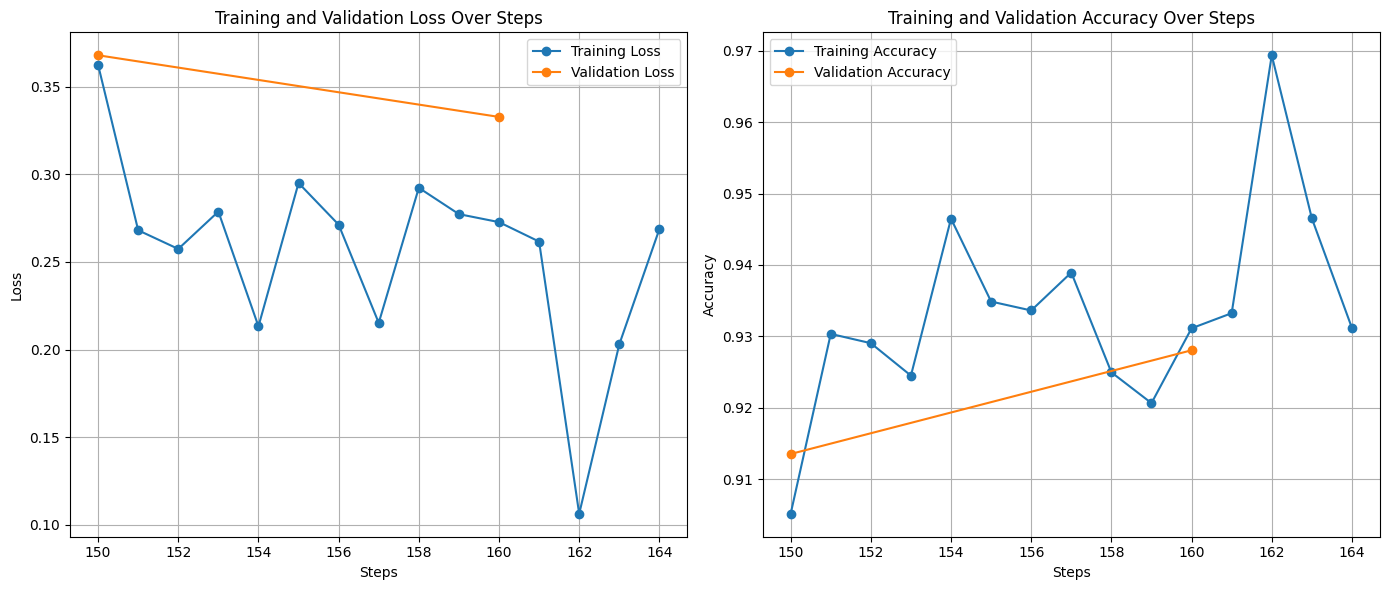

In [ ]:
# Initialize lists to store data
steps = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Iterate through events and extract relevant metrics
for event in events:
    if event["type"] == "metrics":
        data = event["data"]
        step = data.get("step")
        train_loss = data.get("train_loss")
        val_loss = data.get("valid_loss")
        train_acc = data.get("train_mean_token_accuracy")
        val_acc = data.get("valid_mean_token_accuracy")

        # Append values if they exist
        if step is not None:
            steps.append(step)
            train_losses.append(train_loss if train_loss is not None else None)

            # Store (step, val_loss) only if val_loss exists
            if val_loss is not None:
                val_losses.append((step, val_loss))

            train_accuracies.append(train_acc if train_acc is not None else None)

            # Store (step, val_acc) only if val_acc exists
            if val_acc is not None:
                val_accuracies.append((step, val_acc))

# Extract steps and values for validation loss and accuracy, while filtering out any non-tuple data
val_steps, val_loss_values = zip(*[(s, v) for s, v in val_losses if isinstance(v, float)]) if val_losses else ([], [])
val_acc_steps, val_acc_values = zip(*[(s, a) for s, a in val_accuracies if isinstance(a, float)]) if val_accuracies else ([], [])

# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot training and validation loss
axs[0].plot(steps, train_losses, label='Training Loss', marker='o')
if val_steps:
    axs[0].plot(val_steps, val_loss_values, label='Validation Loss', marker='o')
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss Over Steps')
axs[0].legend()
axs[0].grid(True)

# Plot training and validation accuracy
axs[1].plot(steps, train_accuracies, label='Training Accuracy', marker='o')
if val_acc_steps:
    axs[1].plot(val_acc_steps, val_acc_values, label='Validation Accuracy', marker='o')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy Over Steps')
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()